In [1]:
import pandas as pd
import os
import kagglehub
import zipfile
import json
from collections import Counter
import matplotlib.pyplot as plt
from lxml import etree
import xml.etree.ElementTree as ET



Drug A Features:
Drug class,
Mechanism/Target,
chemical structure/SMILE,
known individual side effects,
Administration method and Dosages
elimination pathway (kidneys or liver)
Drugbank: Route of Elimination
Drug B Features:
Same list as Drug A


## **Import Drug Bank**

In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [3]:
path=('/content/drive/MyDrive/drugbank.xml')

print(os.path.exists(path))  # Should return True


True


In [4]:
#File path

with open(path, 'rb') as f:
    try:
        tree = etree.parse(f)
        print("Parsed with lxml!")
    except etree.XMLSyntaxError as e:
        print("lxml error:", e)



Parsed with lxml!


In [5]:
##Looking at root

tree = ET.parse(path)
root = tree.getroot()

print("Root tag:", root.tag)


Root tag: {http://www.drugbank.ca}drugbank


In [10]:
##Lookin at childs
for child in root[:5]:
    print("Tag:", child.tag)
    print("Attributes:", child.attrib)
    print("Text:", child.text.strip() if child.text else None)
    print("---")


Tag: {http://www.drugbank.ca}drug
Attributes: {'type': 'biotech', 'created': '2005-06-13', 'updated': '2024-11-03'}
Text: 
---
Tag: {http://www.drugbank.ca}drug
Attributes: {'type': 'biotech', 'created': '2005-06-13', 'updated': '2025-01-02'}
Text: 
---
Tag: {http://www.drugbank.ca}drug
Attributes: {'type': 'biotech', 'created': '2005-06-13', 'updated': '2024-12-14'}
Text: 
---
Tag: {http://www.drugbank.ca}drug
Attributes: {'type': 'biotech', 'created': '2005-06-13', 'updated': '2025-01-02'}
Text: 
---
Tag: {http://www.drugbank.ca}drug
Attributes: {'type': 'biotech', 'created': '2005-06-13', 'updated': '2024-12-03'}
Text: 
---


In [6]:
##Name space
ns = {'db': 'http://www.drugbank.ca'}


In [7]:
##Total drugs
drugs = root.findall('db:drug', namespaces=ns)

print("Total drugs found:", len(drugs))


Total drugs found: 17430


In [8]:
##looking at all columns available

# Set to collect all unique field names
all_tags = set()

# Function to recursively walk through each element in a drug record
def collect_tags(element, path=''):
    for child in element:
        # Clean up namespace
        tag = child.tag.replace(f'{{{ns["db"]}}}', '')
        full_path = f"{path}/{tag}" if path else tag
        all_tags.add(full_path)
        collect_tags(child, full_path)  # Recursively dive deeper

# Run on first N drugs to limit runtime
for drug in drugs[:50]:
    collect_tags(drug)

# Display all unique tag paths (like column names)
sorted_tags = sorted(all_tags)
for tag in sorted_tags:
    print(tag)


absorption
affected-organisms
affected-organisms/affected-organism
ahfs-codes
atc-codes
atc-codes/atc-code
atc-codes/atc-code/level
average-mass
calculated-properties
calculated-properties/property
calculated-properties/property/kind
calculated-properties/property/source
calculated-properties/property/value
carriers
carriers/carrier
carriers/carrier/actions
carriers/carrier/actions/action
carriers/carrier/id
carriers/carrier/known-action
carriers/carrier/name
carriers/carrier/organism
carriers/carrier/polypeptide
carriers/carrier/polypeptide/amino-acid-sequence
carriers/carrier/polypeptide/cellular-location
carriers/carrier/polypeptide/chromosome-location
carriers/carrier/polypeptide/external-identifiers
carriers/carrier/polypeptide/external-identifiers/external-identifier
carriers/carrier/polypeptide/external-identifiers/external-identifier/identifier
carriers/carrier/polypeptide/external-identifiers/external-identifier/resource
carriers/carrier/polypeptide/gene-name
carriers/carrier/

In [9]:
rows = []

for drug in drugs:
    drug_id = drug.findtext('db:drugbank-id', namespaces=ns)
    drug_name = drug.findtext('db:name', namespaces=ns)

    # Drug Class
    classification = drug.find('db:classification', namespaces=ns)
    drug_class = classification.findtext('db:class', namespaces=ns) if classification is not None else None
    subclass = classification.findtext('db:subclass', namespaces=ns) if classification is not None else None

    # Mechanism / Target
    mechanism = drug.findtext('db:mechanism-of-action', namespaces=ns)

    # SMILES
    smiles = None
    for prop in drug.findall('db:calculated-properties/db:property', namespaces=ns):
        kind = prop.findtext('db:kind', namespaces=ns)
        if kind and kind.lower() == 'smiles':
            smiles = prop.findtext('db:value', namespaces=ns)
            break

    # Side Effects (Toxicity)
    toxicity = drug.findtext('db:toxicity', namespaces=ns)

    # Dosage & Administration Route
    dosage_form = None
    dosage_strength = None
    dosage_route = None
    dosage = drug.find('db:dosages/db:dosage', namespaces=ns)
    if dosage is not None:
        dosage_form = dosage.findtext('db:form', namespaces=ns)
        dosage_strength = dosage.findtext('db:strength', namespaces=ns)
        dosage_route = dosage.findtext('db:route', namespaces=ns)

    # Route of Elimination (kidney/liver)
    elimination_route = drug.findtext('db:route-of-elimination', namespaces=ns)

    rows.append({
        'drugbank_id': drug_id,
        'drug_name': drug_name,
        'drug_class': drug_class,
        'subclass': subclass,
        'mechanism_of_action': mechanism,
        'smiles': smiles,
        'toxicity': toxicity,
        'dosage_form': dosage_form,
        'dosage_strength': dosage_strength,
        'dosage_route': dosage_route,
        'route_of_elimination': elimination_route
    })

df = pd.DataFrame(rows)
df.head()


,drugbank_id,drug_name,drug_class,subclass,mechanism_of_action,smiles,toxicity,dosage_form,dosage_strength,dosage_route,route_of_elimination
0,DB00001,Lepirudin,Carboxylic Acids and Derivatives,"Amino Acids, Peptides, and Analogues",Lepirudin is a direct thrombin inhibitor used ...,None,The acute toxicity of intravenous lepirudin wa...,"Injection, powder, for suspension",5000000 mg,Intravenous,Lepirudin is mostly excreted through urine (48...
1,DB00002,Cetuximab,Carboxylic Acids and Derivatives,"Amino Acids, Peptides, and Analogues",The epidermal growth factor receptor (EGFR) is...,None,The intravenous LD<sub>50</sub> is > 300 mg/kg...,Injection,5 MG/ML,Intravenous,There is limited information available.
2,DB00003,Dornase alfa,Carboxylic Acids and Derivatives,"Amino Acids, Peptides, and Analogues",Dornase alfa is a biosynthetic form of human D...,None,Adverse reactions occur at a frequency of < 1/...,"Aerosol, spray",2.5 mg,Respiratory (inhalation),
3,DB00004,Denileukin diftitox,Carboxylic Acids and Derivatives,"Amino Acids, Peptides, and Analogues",Denileukin diftitox is a fusion protein compos...,None,There is limited information regarding the acu...,"Injection, solution",150 ug/1mL,Intravenous,
4,DB00005,Etanercept,Carboxylic Acids and Derivatives,"Amino Acids, Peptides, and Analogues",There are two distinct receptors for TNF (TNFR...,None,,"Injection, solution",25 MG,Parenteral,


In [10]:
df.to_csv('DrugBankFeatures.csv')

In [12]:
df.columns

Index(['drugbank_id', 'drug_name', 'drug_class', 'subclass',
       'mechanism_of_action', 'smiles', 'toxicity', 'dosage_form',
       'dosage_strength', 'dosage_route', 'route_of_elimination'],
      dtype='object')

In [13]:
for drug in drugs[:5]:
    drugbank_id = drug.find('db:drugbank-id', namespaces=ns)
    name = drug.find('db:name', namespaces=ns)
    description = drug.find('db:description', namespaces=ns)

    print("ID:", drugbank_id.text if drugbank_id is not None else None)
    print("Name:", name.text if name is not None else None)
    print("Description:", description.text[:100] + "..." if description is not None else None)
    print("---")


ID: DB00001
Name: Lepirudin
Description: Lepirudin is a recombinant hirudin formed by 65 amino acids that acts as a highly specific and direc...
---
ID: DB00002
Name: Cetuximab
Description: Cetuximab is a recombinant chimeric human/mouse IgG1 monoclonal antibody that competitively binds to...
---
ID: DB00003
Name: Dornase alfa
Description: Dornase alfa is a biosynthetic form of human deoxyribunuclease I (DNase I) enzyme. It is produced in...
---
ID: DB00004
Name: Denileukin diftitox
Description: Denileukin diftitox is an IL2-receptor-directed cytotoxin, is a recombinant DNA-derived fusion prote...
---
ID: DB00005
Name: Etanercept
Description: Dimeric fusion protein consisting of the extracellular ligand-binding portion of the human 75 kiloda...
---


In [14]:
import pandas as pd

records = []
for drug in drugs:
    record = {
        "drugbank_id": drug.findtext('db:drugbank-id', namespaces=ns),
        "name": drug.findtext('db:name', namespaces=ns),
        "type": drug.attrib.get("type"),
        "created": drug.attrib.get("created"),
        "updated": drug.attrib.get("updated"),
    }
    records.append(record)

df = pd.DataFrame(records)
df.head()


,drugbank_id,name,type,created,updated
0,DB00001,Lepirudin,biotech,2005-06-13,2024-11-03
1,DB00002,Cetuximab,biotech,2005-06-13,2025-01-02
2,DB00003,Dornase alfa,biotech,2005-06-13,2024-12-14
3,DB00004,Denileukin diftitox,biotech,2005-06-13,2025-01-02
4,DB00005,Etanercept,biotech,2005-06-13,2024-12-03


In [36]:
##Looking at interactions
##making basic drug interaction table
interaction_rows = []

for drug in drugs:
    source_id = drug.findtext('db:drugbank-id', namespaces=ns)
    source_name = drug.findtext('db:name', namespaces=ns)

    interactions = drug.findall('db:drug-interactions/db:drug-interaction', namespaces=ns)
    for inter in interactions:
        target_id = inter.findtext('db:drugbank-id', namespaces=ns)
        target_name = inter.findtext('db:name', namespaces=ns)
        description = inter.findtext('db:description', namespaces=ns)

        interaction_rows.append({
            'source_id': source_id,
            'source_name': source_name,
            'target_id': target_id,
            'target_name': target_name,
            'description': description
        })

interactions_df = pd.DataFrame(interaction_rows)
interactions_df.head()


,source_id,source_name,target_id,target_name,description
0,DB00001,Lepirudin,DB06605,Apixaban,Apixaban may increase the anticoagulant activi...
1,DB00001,Lepirudin,DB06695,Dabigatran etexilate,Dabigatran etexilate may increase the anticoag...
2,DB00001,Lepirudin,DB01254,Dasatinib,The risk or severity of bleeding and hemorrhag...
3,DB00001,Lepirudin,DB01609,Deferasirox,The risk or severity of gastrointestinal bleed...
4,DB00001,Lepirudin,DB01586,Ursodeoxycholic acid,The risk or severity of bleeding and bruising ...


In [16]:
interactions_df.to_csv("drug_interactions.csv", index=False)

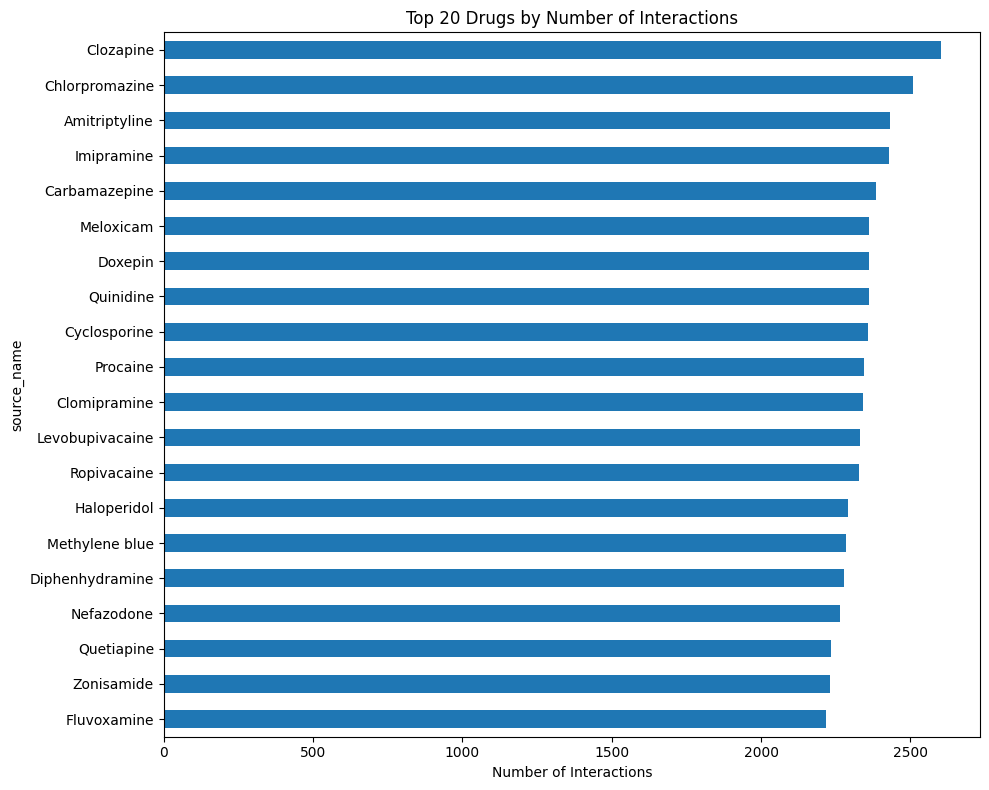

In [17]:
import matplotlib.pyplot as plt

top_drugs = interactions_df['source_name'].value_counts().nlargest(20)

plt.figure(figsize=(10, 8))
top_drugs.sort_values().plot(kind='barh')
plt.xlabel("Number of Interactions")
plt.title("Top 20 Drugs by Number of Interactions")
plt.tight_layout()
plt.show()


In [37]:
##Pharmcaology df
pharmacology_rows = []

for drug in drugs:
    drug_id = drug.findtext('db:drugbank-id', namespaces=ns)
    drug_name = drug.findtext('db:name', namespaces=ns)

    # Pharmacological fields
    indication = drug.findtext('db:indication', namespaces=ns)
    pharmacodynamics = drug.findtext('db:pharmacodynamics', namespaces=ns)
    mechanism = drug.findtext('db:mechanism-of-action', namespaces=ns)
    toxicity = drug.findtext('db:toxicity', namespaces=ns)
    metabolism = drug.findtext('db:metabolism', namespaces=ns)
    absorption = drug.findtext('db:absorption', namespaces=ns)
    half_life = drug.findtext('db:half-life', namespaces=ns)
    route_of_elimination = drug.findtext('db:route-of-elimination', namespaces=ns)
    volume_of_distribution = drug.findtext('db:volume-of-distribution', namespaces=ns)
    clearance = drug.findtext('db:clearance', namespaces=ns)

    pharmacology_rows.append({
        'drugbank_id': drug_id,
        'name': drug_name,
        'indication': indication,
        'pharmacodynamics': pharmacodynamics,
        'mechanism_of_action': mechanism,
        'toxicity': toxicity,
        'metabolism': metabolism,
        'absorption': absorption,
        'half_life': half_life,
        'route_of_elimination': route_of_elimination,
        'volume_of_distribution': volume_of_distribution,
        'clearance': clearance
    })

pharmacology_df = pd.DataFrame(pharmacology_rows)
pharmacology_df.head()


,drugbank_id,name,indication,pharmacodynamics,mechanism_of_action,toxicity,metabolism,absorption,half_life,route_of_elimination,volume_of_distribution,clearance
0,DB00001,Lepirudin,Lepirudin is indicated for anticoagulation in ...,Lepirudin is a recombinant hirudin that acts a...,Lepirudin is a direct thrombin inhibitor used ...,The acute toxicity of intravenous lepirudin wa...,"As a polypeptide, lepirudin is expected to be ...",Lepirudin administered as a single intravenous...,Lepirudin has an initial half-life of approxim...,Lepirudin is mostly excreted through urine (48...,The volume of distribution of lepirudin at ste...,The clearance of lepirudin is proportional to ...
1,DB00002,Cetuximab,Cetuximab indicated for the treatment of local...,Cetuximab is an anticancer agent that works by...,The epidermal growth factor receptor (EGFR) is...,The intravenous LD<sub>50</sub> is > 300 mg/kg...,"Like other monoclonal antibodies, cetuximab is...",After administration of a 400 mg/m<sup>2</sup>...,After administration of a 400 mg/m<sup>2</sup>...,There is limited information available.,The volume of the distribution is about 2-3 L/...,In patients with recurrent and/or metastatic s...
2,DB00003,Dornase alfa,Used as adjunct therapy in the treatment of cy...,Cystic fibrosis (CF) is a disease characterize...,Dornase alfa is a biosynthetic form of human D...,Adverse reactions occur at a frequency of < 1/...,While no conclusive studies have yet been publ...,Studies in rats and monkeys after inhalation o...,,,"In studies in rats and monkeys, the initial vo...","Studies in rats indicate that, following aeros..."
3,DB00004,Denileukin diftitox,Denileukin diftitox was previously indicated f...,Denileukin diftitox is an anticancer drug with...,Denileukin diftitox is a fusion protein compos...,There is limited information regarding the acu...,Denileukin diftitox is expected to be metaboli...,Following a single dose of denileukin diftitox...,The arithmetic mean (CV%) denileukin diftitox ...,,The geometric mean (CV%) volume of distributio...,The geometric mean (CV%) clearance is 36.5 mL/...
4,DB00005,Etanercept,Etanercept is indicated for the treatment of m...,Etanercept binds specifically to tumor necrosi...,There are two distinct receptors for TNF (TNFR...,,"As etanercept is a fusion protein antibody, it...",Population pharmacokinetic modeling in adults ...,Etanercept has a mean half-life of elimination...,,Population pharmacokinetic modeling predicts a...,Etanercept has a mean apparent clearance of 16...


In [38]:
pharmacology_df.to_csv('pharmacology.csv')

In [40]:
##Making basic drug table

drug_rows = []

for drug in drugs:
    drug_rows.append({
        'drugbank_id': drug.findtext('db:drugbank-id', namespaces=ns),
        'name': drug.findtext('db:name', namespaces=ns),
        'type': drug.attrib.get('type'),
        'created': drug.attrib.get('created'),
        'updated': drug.attrib.get('updated'),
        'description': drug.findtext('db:description', namespaces=ns),
    })

drugs_df = pd.DataFrame(drug_rows)

drugs_df.head()


,drugbank_id,name,type,created,updated,description
0,DB00001,Lepirudin,biotech,2005-06-13,2024-11-03,Lepirudin is a recombinant hirudin formed by 6...
1,DB00002,Cetuximab,biotech,2005-06-13,2025-01-02,Cetuximab is a recombinant chimeric human/mous...
2,DB00003,Dornase alfa,biotech,2005-06-13,2024-12-14,Dornase alfa is a biosynthetic form of human d...
3,DB00004,Denileukin diftitox,biotech,2005-06-13,2025-01-02,Denileukin diftitox is an IL2-receptor-directe...
4,DB00005,Etanercept,biotech,2005-06-13,2024-12-03,Dimeric fusion protein consisting of the extra...


In [41]:
drugs_df.to_csv('basic_drug.csv')

In [45]:
target_rows = []

for drug in drugs:
    drug_id = drug.findtext('db:drugbank-id', namespaces=ns)
    drug_name = drug.findtext('db:name', namespaces=ns)
    targets = drug.findall('db:targets/db:target', namespaces=ns)

    for t in targets:
        polypep = t.find('db:polypeptide', namespaces=ns)
        if polypep is not None:
            target_rows.append({
                'drugbank_id': drug_id,
                'drug_name': drug_name,
                'target_name': polypep.findtext('db:name', namespaces=ns),
                'gene_name': polypep.findtext('db:gene-name', namespaces=ns),
                'uniprot_id': polypep.attrib.get('id'),  # This one is still in attribute
                'organism': polypep.findtext('db:organism', namespaces=ns)
            })

targets_df = pd.DataFrame(target_rows)
targets_df.head()


,drugbank_id,drug_name,target_name,gene_name,uniprot_id,organism
0,DB00001,Lepirudin,Prothrombin,F2,P00734,Humans
1,DB00002,Cetuximab,Epidermal growth factor receptor,EGFR,P00533,Humans
2,DB00002,Cetuximab,Low affinity immunoglobulin gamma Fc region re...,FCGR3B,O75015,Humans
3,DB00002,Cetuximab,Complement C1q subcomponent subunit A,C1QA,P02745,Humans
4,DB00002,Cetuximab,Complement C1q subcomponent subunit B,C1QB,P02746,Humans


In [47]:
targets_df.to_csv('targets.csv')

In [50]:
enzyme_rows = []

for drug in drugs:
    drug_id = drug.findtext('db:drugbank-id', namespaces=ns)
    drug_name = drug.findtext('db:name', namespaces=ns)
    enzymes = drug.findall('db:enzymes/db:enzyme', namespaces=ns)

    for enz in enzymes:
        polypep = enz.find('db:polypeptide', namespaces=ns)
        if polypep is not None:
            enzyme_rows.append({
                'drugbank_id': drug_id,
                'drug_name': drug_name,
                'enzyme_name': polypep.findtext('db:name', namespaces=ns),
                'gene_name': polypep.findtext('db:gene-name', namespaces=ns),
                'uniprot_id': polypep.attrib.get('id'),  # Still an attribute
                'organism': polypep.findtext('db:organism', namespaces=ns)
            })

enzymes_df = pd.DataFrame(enzyme_rows)
enzymes_df.head()


,drugbank_id,drug_name,enzyme_name,gene_name,uniprot_id,organism
0,DB00006,Bivalirudin,Myeloperoxidase,MPO,P05164,Humans
1,DB00008,Peginterferon alfa-2a,Cytochrome P450 1A2,CYP1A2,P05177,Humans
2,DB00011,Interferon alfa-n1,Cytochrome P450 1A2,CYP1A2,P05177,Humans
3,DB00013,Urokinase,Macrophage metalloelastase,MMP12,P39900,Humans
4,DB00018,Interferon alfa-n3,Cytochrome P450 1A2,CYP1A2,P05177,Humans


In [52]:
enzymes_df.to_csv('enzymes.csv')

# **Import Kaggle dataset**

In [ ]:
##Path for kaggle dataset
path = kagglehub.dataset_download("mghobashy/drug-drug-interactions")

print("Path to dataset files:", path)

kaggle_drug = pd.read_csv(os.path.join(path, "db_drug_interactions.csv"))

print(kaggle_drug.head())

100%|██████████| 1.83M/1.83M [00:00<00:00, 82.3MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mghobashy/drug-drug-interactions/versions/1


                Drug 1       Drug 2  \
0           Trioxsalen  Verteporfin   
1  Aminolevulinic acid  Verteporfin   
2     Titanium dioxide  Verteporfin   
3     Tiaprofenic acid  Verteporfin   
4          Cyamemazine  Verteporfin   

                             Interaction Description  
0  Trioxsalen may increase the photosensitizing a...  
1  Aminolevulinic acid may increase the photosens...  
2  Titanium dioxide may increase the photosensiti...  
3  Tiaprofenic acid may increase the photosensiti...  
4  Cyamemazine may increase the photosensitizing ...  


# **National Library of Medicine Data**
https://dailymed.nlm.nih.gov/dailymed/spl-resources-all-mapping-files.cfm

In [ ]:
##All text files, didnt seem too important, uploaded to the folder in case

# **FDA Data**

In [ ]:
json_path = "/content/drug-drugsfda-0001-of-0001.json"
with open(json_path, 'r') as f:
    data = json.load(f)

##Has both resutls and meta data
results = data["results"]

fda = pd.json_normalize(results)

fda

,submissions,application_number,sponsor_name,products,openfda.application_number,openfda.brand_name,openfda.generic_name,openfda.manufacturer_name,openfda.product_ndc,openfda.product_type,...,openfda.rxcui,openfda.spl_id,openfda.spl_set_id,openfda.package_ndc,openfda.unii,openfda.nui,openfda.pharm_class_pe,openfda.pharm_class_epc,openfda.pharm_class_cs,openfda.pharm_class_moa
0,"[{'submission_type': 'ORIG', 'submission_numbe...",NDA000159,LILLY,"[{'product_number': '001', 'reference_drug': '...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076175,CHARTWELL RX,"[{'product_number': '001', 'reference_drug': '...",[ANDA076175],[MEFLOQUINE HYDROCHLORIDE],[MEFLOQUINE HYDROCHLORIDE],"[Chartwell RX, LLC]",[62135-973],[HUMAN PRESCRIPTION DRUG],...,[835913],[2732839a-191a-570f-e063-6294a90a40a4],[b884d22b-aae7-4f14-9a04-ae4029a229f0],"[62135-973-25, 62135-973-11]",[5Y9L3636O3],NaN,NaN,NaN,NaN,NaN
2,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076194,WATSON LABS,"[{'product_number': '003', 'reference_drug': '...",[ANDA076194],[LISINOPRIL AND HYDROCHLOROTHIAZIDE],[LISINOPRIL AND HYDROCHLOROTHIAZIDE],"[Actavis Pharma, Inc.]","[0591-0860, 0591-0861, 0591-0862]",[HUMAN PRESCRIPTION DRUG],...,"[197885, 197886, 197887]",[ff5e5610-775f-48a9-a410-e8d8b547b958],[ab5e9ae4-e575-4a63-99f3-2bde36bdd508],"[0591-0860-01, 0591-0860-05, 0591-0861-01, 059...","[0J48LPH2TH, E7199S1YWR]","[N0000175359, N0000175419, M0471776]",[Increased Diuresis [PE]],[Thiazide Diuretic [EPC]],[Thiazides [CS]],NaN
3,"[{'submission_type': 'ORIG', 'submission_numbe...",ANDA076202,GAVIS PHARMS,"[{'product_number': '001', 'reference_drug': '...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076236,BARR,"[{'product_number': '001', 'reference_drug': '...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28239,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076135,TEVA PHARMS USA,"[{'product_number': '003', 'reference_drug': '...",[ANDA076135],[CLARAVIS],[ISOTRETINOIN],"[Teva Pharmaceuticals USA, Inc.]","[0555-1055, 0555-1054, 0555-1056, 0555-1057]",[HUMAN PRESCRIPTION DRUG],...,"[197843, 197844, 197845, 403930, 404059, 40406...",[a69dde5d-5585-4313-be43-02d11fec4c9f],[a31fd109-d0fd-4ab9-ba98-a3d64333c18d],"[0555-1054-60, 0555-1054-86, 0555-1054-56, 055...",[EH28UP18IF],"[N0000175607, M0018962]",NaN,[Retinoid [EPC]],[Retinoids [CS]],NaN
28240,"[{'submission_type': 'ORIG', 'submission_numbe...",ANDA076136,TEVA,"[{'product_number': '002', 'reference_drug': '...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28241,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076138,NOSTRUM LABS,"[{'product_number': '003', 'reference_drug': '...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28242,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076159,ENDO OPERATIONS,"[{'product_number': '002', 'reference_drug': '...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
##exploding products
df_exploded = fda.explode("products")

products_df = pd.json_normalize(df_exploded["products"])

##combine
df_combined = pd.concat([df_exploded.drop(columns=["products"]).reset_index(drop=True),
                         products_df.reset_index(drop=True)], axis=1)

df_combined


,submissions,application_number,sponsor_name,openfda.application_number,openfda.brand_name,openfda.generic_name,openfda.manufacturer_name,openfda.product_ndc,openfda.product_type,openfda.route,...,openfda.pharm_class_moa,product_number,reference_drug,brand_name,active_ingredients,reference_standard,dosage_form,route,marketing_status,te_code
0,"[{'submission_type': 'ORIG', 'submission_numbe...",NDA000159,LILLY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,001,No,SULFAPYRIDINE,"[{'name': 'SULFAPYRIDINE', 'strength': '500MG'}]",No,TABLET,ORAL,Discontinued,NaN
1,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076175,CHARTWELL RX,[ANDA076175],[MEFLOQUINE HYDROCHLORIDE],[MEFLOQUINE HYDROCHLORIDE],"[Chartwell RX, LLC]",[62135-973],[HUMAN PRESCRIPTION DRUG],[ORAL],...,NaN,001,No,MEFLOQUINE HYDROCHLORIDE,"[{'name': 'MEFLOQUINE HYDROCHLORIDE', 'strengt...",No,TABLET,ORAL,Discontinued,NaN
2,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076194,WATSON LABS,[ANDA076194],[LISINOPRIL AND HYDROCHLOROTHIAZIDE],[LISINOPRIL AND HYDROCHLOROTHIAZIDE],"[Actavis Pharma, Inc.]","[0591-0860, 0591-0861, 0591-0862]",[HUMAN PRESCRIPTION DRUG],[ORAL],...,NaN,003,No,LISINOPRIL AND HYDROCHLOROTHIAZIDE,"[{'name': 'HYDROCHLOROTHIAZIDE', 'strength': '...",No,TABLET,ORAL,Prescription,AB
3,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076194,WATSON LABS,[ANDA076194],[LISINOPRIL AND HYDROCHLOROTHIAZIDE],[LISINOPRIL AND HYDROCHLOROTHIAZIDE],"[Actavis Pharma, Inc.]","[0591-0860, 0591-0861, 0591-0862]",[HUMAN PRESCRIPTION DRUG],[ORAL],...,NaN,001,No,LISINOPRIL AND HYDROCHLOROTHIAZIDE,"[{'name': 'HYDROCHLOROTHIAZIDE', 'strength': '...",No,TABLET,ORAL,Prescription,AB
4,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076194,WATSON LABS,[ANDA076194],[LISINOPRIL AND HYDROCHLOROTHIAZIDE],[LISINOPRIL AND HYDROCHLOROTHIAZIDE],"[Actavis Pharma, Inc.]","[0591-0860, 0591-0861, 0591-0862]",[HUMAN PRESCRIPTION DRUG],[ORAL],...,NaN,002,No,LISINOPRIL AND HYDROCHLOROTHIAZIDE,"[{'name': 'HYDROCHLOROTHIAZIDE', 'strength': '...",No,TABLET,ORAL,Prescription,AB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49753,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076138,NOSTRUM LABS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,001,No,CIPROFLOXACIN HYDROCHLORIDE,"[{'name': 'CIPROFLOXACIN HYDROCHLORIDE', 'stre...",No,TABLET,ORAL,Discontinued,NaN
49754,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076138,NOSTRUM LABS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,002,No,CIPROFLOXACIN HYDROCHLORIDE,"[{'name': 'CIPROFLOXACIN HYDROCHLORIDE', 'stre...",No,TABLET,ORAL,Discontinued,NaN
49755,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076159,ENDO OPERATIONS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,002,No,GLIPIZIDE,"[{'name': 'GLIPIZIDE', 'strength': '5MG'}]",No,"TABLET, EXTENDED RELEASE",ORAL,Discontinued,NaN
49756,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076159,ENDO OPERATIONS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,001,No,GLIPIZIDE,"[{'name': 'GLIPIZIDE', 'strength': '10MG'}]",No,"TABLET, EXTENDED RELEASE",ORAL,Discontinued,NaN


In [ ]:
##Now exploding active ingrediants
df_ingredients_exploded = df_combined.explode("active_ingredients")

ingredients_df = pd.json_normalize(df_ingredients_exploded["active_ingredients"])

##combine
df_final_fda = pd.concat([df_ingredients_exploded.drop(columns=["active_ingredients"]).reset_index(drop=True),
                      ingredients_df.reset_index(drop=True)], axis=1)

##final from fda
print(df_final_fda.head())

df_final_fda


                                         submissions application_number  \
0  [{'submission_type': 'ORIG', 'submission_numbe...          NDA000159   
1  [{'submission_type': 'SUPPL', 'submission_numb...         ANDA076175   
2  [{'submission_type': 'SUPPL', 'submission_numb...         ANDA076194   
3  [{'submission_type': 'SUPPL', 'submission_numb...         ANDA076194   
4  [{'submission_type': 'SUPPL', 'submission_numb...         ANDA076194   

   sponsor_name openfda.application_number  \
0         LILLY                        NaN   
1  CHARTWELL RX               [ANDA076175]   
2   WATSON LABS               [ANDA076194]   
3   WATSON LABS               [ANDA076194]   
4   WATSON LABS               [ANDA076194]   

                     openfda.brand_name                  openfda.generic_name  \
0                                   NaN                                   NaN   
1            [MEFLOQUINE HYDROCHLORIDE]            [MEFLOQUINE HYDROCHLORIDE]   
2  [LISINOPRIL AND HYDROCHLOR

,submissions,application_number,sponsor_name,openfda.application_number,openfda.brand_name,openfda.generic_name,openfda.manufacturer_name,openfda.product_ndc,openfda.product_type,openfda.route,...,product_number,reference_drug,brand_name,reference_standard,dosage_form,route,marketing_status,te_code,name,strength
0,"[{'submission_type': 'ORIG', 'submission_numbe...",NDA000159,LILLY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,001,No,SULFAPYRIDINE,No,TABLET,ORAL,Discontinued,NaN,SULFAPYRIDINE,500MG
1,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076175,CHARTWELL RX,[ANDA076175],[MEFLOQUINE HYDROCHLORIDE],[MEFLOQUINE HYDROCHLORIDE],"[Chartwell RX, LLC]",[62135-973],[HUMAN PRESCRIPTION DRUG],[ORAL],...,001,No,MEFLOQUINE HYDROCHLORIDE,No,TABLET,ORAL,Discontinued,NaN,MEFLOQUINE HYDROCHLORIDE,250MG
2,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076194,WATSON LABS,[ANDA076194],[LISINOPRIL AND HYDROCHLOROTHIAZIDE],[LISINOPRIL AND HYDROCHLOROTHIAZIDE],"[Actavis Pharma, Inc.]","[0591-0860, 0591-0861, 0591-0862]",[HUMAN PRESCRIPTION DRUG],[ORAL],...,003,No,LISINOPRIL AND HYDROCHLOROTHIAZIDE,No,TABLET,ORAL,Prescription,AB,HYDROCHLOROTHIAZIDE,12.5MG
3,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076194,WATSON LABS,[ANDA076194],[LISINOPRIL AND HYDROCHLOROTHIAZIDE],[LISINOPRIL AND HYDROCHLOROTHIAZIDE],"[Actavis Pharma, Inc.]","[0591-0860, 0591-0861, 0591-0862]",[HUMAN PRESCRIPTION DRUG],[ORAL],...,003,No,LISINOPRIL AND HYDROCHLOROTHIAZIDE,No,TABLET,ORAL,Prescription,AB,LISINOPRIL,10MG
4,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076194,WATSON LABS,[ANDA076194],[LISINOPRIL AND HYDROCHLOROTHIAZIDE],[LISINOPRIL AND HYDROCHLOROTHIAZIDE],"[Actavis Pharma, Inc.]","[0591-0860, 0591-0861, 0591-0862]",[HUMAN PRESCRIPTION DRUG],[ORAL],...,001,No,LISINOPRIL AND HYDROCHLOROTHIAZIDE,No,TABLET,ORAL,Prescription,AB,HYDROCHLOROTHIAZIDE,12.5MG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58019,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076138,NOSTRUM LABS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,001,No,CIPROFLOXACIN HYDROCHLORIDE,No,TABLET,ORAL,Discontinued,NaN,CIPROFLOXACIN HYDROCHLORIDE,EQ 250MG BASE
58020,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076138,NOSTRUM LABS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,002,No,CIPROFLOXACIN HYDROCHLORIDE,No,TABLET,ORAL,Discontinued,NaN,CIPROFLOXACIN HYDROCHLORIDE,EQ 500MG BASE
58021,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076159,ENDO OPERATIONS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,002,No,GLIPIZIDE,No,"TABLET, EXTENDED RELEASE",ORAL,Discontinued,NaN,GLIPIZIDE,5MG
58022,"[{'submission_type': 'SUPPL', 'submission_numb...",ANDA076159,ENDO OPERATIONS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,001,No,GLIPIZIDE,No,"TABLET, EXTENDED RELEASE",ORAL,Discontinued,NaN,GLIPIZIDE,10MG


# **Hugging Face Dataset**

In [1]:
clinical_notes= pd.read_json("hf://datasets/AGBonnet/augmented-clinical-notes/augmented_notes_30K.jsonl", lines=True)

NameError: name 'pd' is not defined

In [ ]:
clinical_notes

,note,conversation,idx,summary,full_note
0,"A a sixteen year-old girl, presented to our Ou...","Doctor: Good morning, what brings you to the O...",155216,"{\n""visit motivation"": ""Discomfort in the neck...","A a sixteen year-old girl, presented to our Ou..."
1,This is the case of a 56-year-old man that was...,"Doctor: Hi, how are you feeling today?\nPatien...",77465,"{\n""visit motivation"": ""Complaints of a dull p...",This is the case of a 56-year-old man that was...
2,A 36-year old female patient visited our hospi...,"Doctor: Hello, what brings you to the hospital...",133948,"{\n""visit motivation"": ""Pain and restricted ra...",A 36-year old female patient visited our hospi...
3,A 49-year-old male presented with a complaint ...,"Doctor: Good morning, Mr. [Patient's Name]. I'...",80176,"{\n""visit motivation"": ""Pain in the left proxi...",A 49-year-old male presented with a complaint ...
4,A 47-year-old male patient was referred to the...,"Doctor: Good morning, how are you feeling toda...",72232,"{\n""visit motivation"": ""Recurrent attacks of p...",A 47-year-old male patient was referred to the...
...,...,...,...,...,...
29995,A 28-year-old male was admitted to the emergen...,"Doctor: Good morning, sir. Can you tell me wha...",39279,"{\n""visit motivation"": ""Stab wound under left ...",A 28-year-old male was admitted to the emergen...
29996,"An 82-year-old man (64.5 kg, 175 cm) diagnosed...","Doctor: Good morning, sir. I am Dr. John. How ...",137017,"{\n""visit motivation"": ""Diagnosed with falcine...","An 82-year-old man (64.5 kg, 175 cm) diagnosed..."
29997,A 54 year-old man with no past medical history...,"Doctor: Good morning, how are you feeling toda...",98004,"{\n""visit motivation"": ""Cardiac sounding chest...",A 54 year-old man with no past medical history...
29998,A 49-year-old woman visited the clinic due to ...,"Doctor: Good morning, how can I help you today...",133320,"{\n""visit motivation"": ""Mass in her right thig...",A 49-year-old woman visited the clinic due to ...


#**MIMIC DATA**


In [ ]:
mimic_data_prescription=pd.read_csv("/content/prescriptions (1).csv.crdownload")
mimic_data_prescription.head()

,subject_id,hadm_id,pharmacy_id,poe_id,poe_seq,starttime,stoptime,drug_type,drug,formulary_drug_cd,gsn,ndc,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route
0,10000032,22595853,11700683,10000032-34,34.0,2180-05-07 01:00:00,2180-05-07 22:00:00,MAIN,Acetaminophen,APAP500,004490,9.041989e+08,500mg Tablet,NaN,500,mg,1,TAB,NaN,PO/NG
1,10000032,22595853,14779570,10000032-22,22.0,2180-05-07 00:00:00,2180-05-07 22:00:00,MAIN,Sodium Chloride 0.9% Flush,NACLFLUSH,NaN,0.000000e+00,10 mL Syringe,NaN,3,mL,0.3,SYR,3.0,IV
2,10000032,22595853,19796602,10000032-50,50.0,2180-05-08 08:00:00,2180-05-07 22:00:00,MAIN,Furosemide,FURO40,008209,5.107901e+10,40mg Tablet,NaN,40,mg,1,TAB,1.0,PO/NG
3,10000032,22595853,20256254,10000032-32,32.0,2180-05-07 01:00:00,2180-05-07 22:00:00,MAIN,Raltegravir,RALT400,063231,6.022761e+06,400 mg Tablet,NaN,400,mg,1,TAB,2.0,PO
4,10000032,22595853,28781051,10000032-27,27.0,2180-05-07 00:00:00,2180-05-07 22:00:00,MAIN,Heparin,HEPA5I,006549,6.332303e+10,5000 Units / mL- 1mL Vial,NaN,5000,UNIT,1,mL,3.0,SC


In [ ]:
mimic_data_prescription.to_csv("mimic_prescription.csv")

# **FINAL COLUMNS**

In [ ]:
df_final_fda.columns


Index(['submissions', 'application_number', 'sponsor_name',
       'openfda.application_number', 'openfda.brand_name',
       'openfda.generic_name', 'openfda.manufacturer_name',
       'openfda.product_ndc', 'openfda.product_type', 'openfda.route',
       'openfda.substance_name', 'openfda.rxcui', 'openfda.spl_id',
       'openfda.spl_set_id', 'openfda.package_ndc', 'openfda.unii',
       'openfda.nui', 'openfda.pharm_class_pe', 'openfda.pharm_class_epc',
       'openfda.pharm_class_cs', 'openfda.pharm_class_moa', 'product_number',
       'reference_drug', 'brand_name', 'reference_standard', 'dosage_form',
       'route', 'marketing_status', 'te_code', 'name', 'strength'],
      dtype='object')

In [ ]:
clinical_notes.columns


Index(['note', 'conversation', 'idx', 'summary', 'full_note'], dtype='object')

In [ ]:
kaggle_drug.columns

Index(['Drug 1', 'Drug 2', 'Interaction Description'], dtype='object')

# **EDA on FDA**

In [ ]:
#Flatten and count
flat_pharm_names = [name for sublist in df_final_fda["openfda.pharm_class_pe"].dropna() for name in sublist]

pharm_class_pe = Counter(flat_pharm_names)

##Count df
pharm_class_pe_df = pd.DataFrame(pharm_class_pe.items(), columns=["pharm_class", "count"]).sort_values(by="count", ascending=False)

print("Top 10 Pharmacologic Classes (Physiologic Effect):\n", pharm_class_pe_df.head(10))




Top 10 Pharmacologic Classes (Physiologic Effect):
                                           pharm_class  count
0                             Increased Diuresis [PE]    838
9   Decreased Central Nervous System Disorganized ...    759
2             Central Nervous System Stimulation [PE]    173
10                                  Vasodilation [PE]    141
20                Decreased Platelet Aggregation [PE]    107
11           Increased Diuresis at Loop of Henle [PE]    103
26     Decreased Respiratory Secretion Viscosity [PE]     90
8               Decreased Cholesterol Absorption [PE]     80
22                Decreased Immunologic Activity [PE]     78
21                        Microtubule Inhibition [PE]     74


<Figure size 1000x500 with 0 Axes>

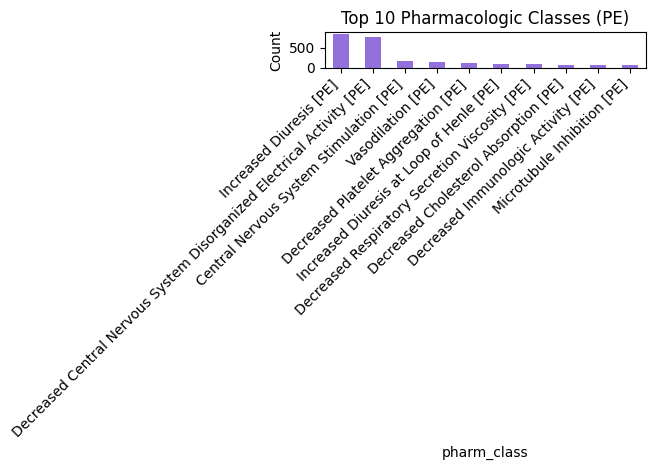

In [ ]:
##Visualize
plt.figure(figsize=(10, 5))
pharm_class_pe_df.head(10).plot.bar(x="pharm_class", y="count", legend=False, title="Top 10 Pharmacologic Classes (PE)", color="mediumpurple")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
##Count values for binary flags
ref_drug_counts = df_final_fda["reference_drug"].value_counts(dropna=False)
ref_std_counts = df_final_fda["reference_standard"].value_counts(dropna=False)
marketing_status_counts = df_final_fda["marketing_status"].value_counts(dropna=False)

print("Reference Drug Flag Counts:\n", ref_drug_counts)
print("\nReference Standard Flag Counts:\n", ref_std_counts)
print("\nMarketing Status Distribution:\n", marketing_status_counts)


Reference Drug Flag Counts:
 reference_drug
No     48403
Yes     9157
NaN      361
TBD      103
Name: count, dtype: int64

Reference Standard Flag Counts:
 reference_standard
No                        50818
Yes                        5257
NaN                        1948
ESOMEPRAZOLE MAGNESIUM        1
Name: count, dtype: int64

Marketing Status Distribution:
 marketing_status
Prescription                 28902
Discontinued                 26203
None (Tentative Approval)     1606
Over-the-counter               953
NaN                            360
Name: count, dtype: int64


In [ ]:
##remove unexpected non-binary string
df_final_fda["reference_standard"] =  df_final_fda["reference_standard"].replace("ESOMEPRAZOLE MAGNESIUM", pd.NA)


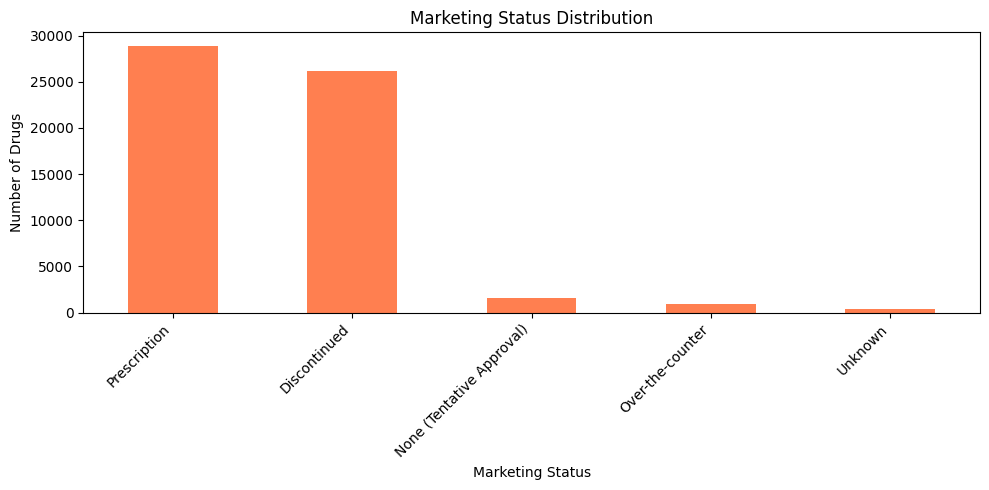

In [ ]:
##Replace missing/NaN values
df_final_fda["marketing_status_clean"] = df_final_fda["marketing_status"].fillna("Unknown")

##Count
marketing_counts = df_final_fda["marketing_status_clean"].value_counts()

##Viusalise
plt.figure(figsize=(10, 5))
marketing_counts.plot(kind="bar", color="coral")
plt.title("Marketing Status Distribution")
plt.xlabel("Marketing Status")
plt.ylabel("Number of Drugs")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# **EDA on clinical_notes**

In [ ]:
##Length
print("Total rows:", len(clinical_notes))
print("Unique idx values:", len(set(clinical_notes['idx'])))


Total rows: 30000
Unique idx values: 30000


In [ ]:
#Notes df
df_notes = pd.DataFrame(clinical_notes)

##length
df_notes["note_length"] = df_notes["note"].str.len()
df_notes["summary_length"] = df_notes["summary"].str.len()
df_notes["full_note_length"] = df_notes["full_note"].str.len()

print(df_notes[["note_length", "summary_length", "full_note_length"]].describe())


        note_length  summary_length  full_note_length
count  30000.000000    30000.000000      30000.000000
mean    2050.386533     3476.303200       3441.443667
std       91.738198      641.547313       1473.074268
min     1689.000000      864.000000        746.000000
25%     1988.000000     3050.000000       2456.000000
50%     2048.000000     3417.000000       3034.000000
75%     2111.000000     3840.000000       3953.000000
max     2445.000000     7904.000000      30995.000000


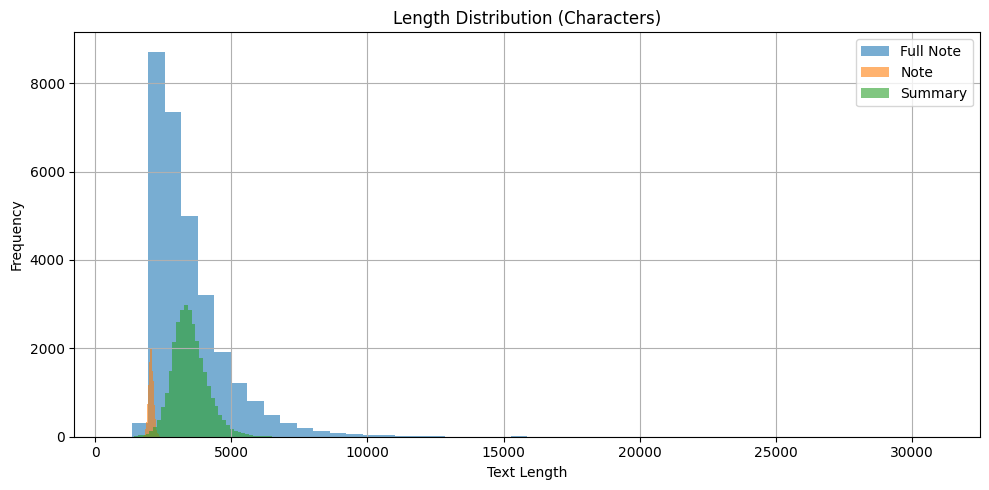

In [ ]:
##Visualize
plt.figure(figsize=(10, 5))
df_notes["full_note_length"].hist(bins=50, alpha=0.6, label="Full Note")
df_notes["note_length"].hist(bins=50, alpha=0.6, label="Note")
df_notes["summary_length"].hist(bins=50, alpha=0.6, label="Summary")
plt.legend()
plt.title("Length Distribution (Characters)")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [ ]:
##key word analysis
#brianstorm
keywords = ["prescribed", "prescription", "tablet", "capsule", "medication", "drug", "mg", "dose", "take", "administer"]

#Combine into regex pattern (case-insensitive)
pattern = r"\b(" + "|".join(keywords) + r")\b"

#Apply to full_note (or note) column
df_notes["has_drug"] = df_notes["full_note"].str.contains(pattern, case=False, na=False)

#Count how many notes mention drugs
drug_mention_count = df_notes["has_drug"].sum()
print(f"🧾 Notes mentioning drugs/prescriptions: {drug_mention_count} / {len(df_notes)}")


<ipython-input-20-aa9b5b1051fa>:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_notes["has_drug"] = df_notes["full_note"].str.contains(pattern, case=False, na=False)


🧾 Notes mentioning drugs/prescriptions: 14719 / 30000


# **Kaggle EDA**

In [ ]:
print("Total interactions:", len(kaggle_drug))


Total interactions: 191541


In [ ]:
##Count drugs
drug_counts = Counter(kaggle_drug['Drug 1']) + Counter(kaggle_drug['Drug 2'])

# Top 10
top_drugs = pd.DataFrame(drug_counts.items(), columns=['drug', 'interaction_count']).sort_values(by='interaction_count', ascending=False)
print(top_drugs.head(10))


               drug  interaction_count
22    Phenobarbital                920
21        Primidone                896
17        Phenytoin                895
19     Fosphenytoin                877
20    Carbamazepine                868
1017    Venlafaxine                860
761     Fluvoxamine                845
23    Pentobarbital                845
478      Amiodarone                844
1016     Nefazodone                815


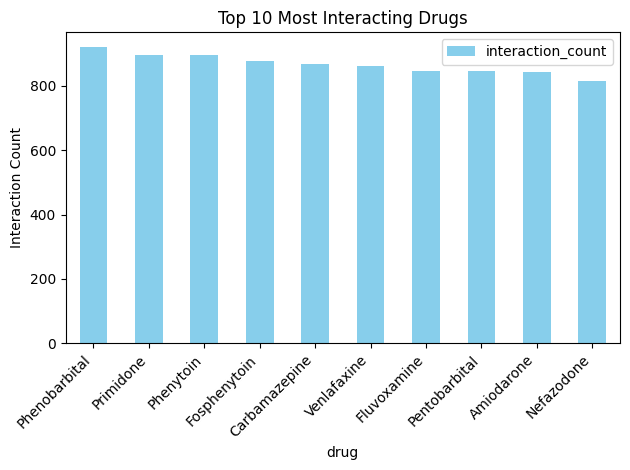

In [ ]:
##visualize
top_drugs.head(10).plot.bar(x='drug', y='interaction_count', color='skyblue', title="Top 10 Most Interacting Drugs")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Interaction Count")
plt.tight_layout()
plt.show()


In [ ]:
##Common word analysis
kaggle_drug["interaction_lower"] = kaggle_drug["Interaction Description"].str.lower()

#Most common interaction
interaction_words = kaggle_drug["interaction_lower"].str.cat(sep=' ').split()
interaction_word_counts = Counter(interaction_words)
print("Top 20 common words in interaction descriptions:")
print(interaction_word_counts.most_common(20))


Top 20 common words in interaction descriptions:
[('of', 192471), ('the', 192356), ('can', 144286), ('when', 143338), ('with', 143338), ('be', 143311), ('combined', 134466), ('is', 95443), ('increased', 91027), ('risk', 61397), ('or', 61370), ('severity', 61370), ('adverse', 60909), ('effects', 60722), ('decreased', 52082), ('may', 47228), ('activities', 45339), ('metabolism', 39313), ('increase', 38937), ('serum', 36850)]


#**MIMIC EDA**